In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py

## Task 1: CNNs for Galaxy Classification

In [2]:
# create data folder if it does not exist
import os
os.makedirs("data", exist_ok=True)

import urllib.request
_, msg = urllib.request.urlretrieve(
    "http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5", 
    "data/Galaxy10.h5"
)

In [2]:
label_names = [
    'Disk, Face-on, No Spiral',
    'Smooth, Completely round',
    'Smooth, in-between round',
    'Smooth, Cigar shaped',
    'Disk, Edge-on, Rounded Bulge',
    'Disk, Edge-on, Boxy Bulge',
    'Disk, Edge-on, No Bulge',
    'Disk, Face-on, Tight Spiral',
    'Disk, Face-on, Medium Spiral',
    'Disk, Face-on, Loose Spiral'
]
n_classes = len(label_names)

# To get the images and labels from file
with h5py.File('data/Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
images = images.astype(np.float32)

# comply to (batch, channel, height, width) convention of pytorch
images = np.moveaxis(images, -1, 1)  
# convert to torch

print(f'{images.shape=}, {labels.shape=}')

images.shape=(21785, 3, 69, 69), labels.shape=(21785,)


### (a)

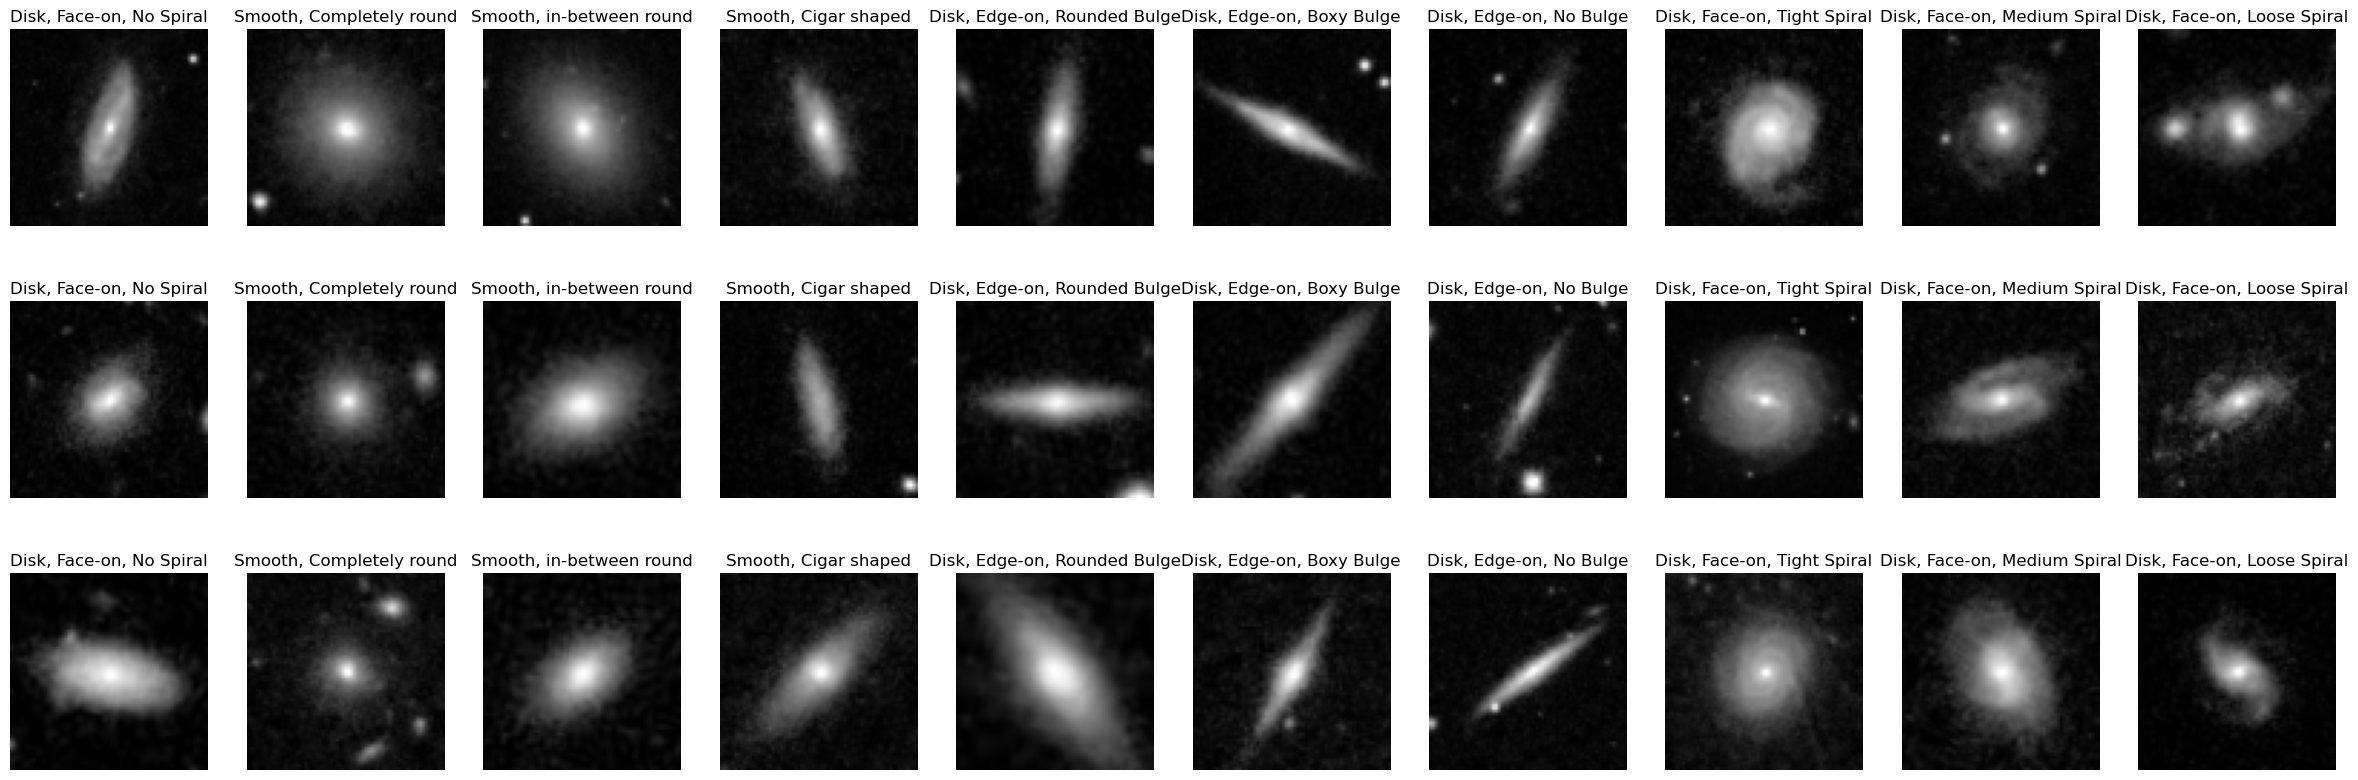

In [ ]:
# TODO: plot three samples of each class

np.random.seed(42)

fig, axs = plt.subplots(3, n_classes, figsize=(30, 10))
for i in range(n_classes):
    for j in range(3):
        idx = np.random.choice(np.where(labels == i)[0])
        axs[j, i].imshow(images[idx, 0], cmap='gray')
        axs[j, i].set_title(label_names[i])
        axs[j, i].axis('off')

In [ ]:
from torchvision.transforms import Normalize
import torch
from torch.utils.data import TensorDataset, DataLoader

images = torch.from_numpy(images)
labels = torch.from_numpy(labels)

In [57]:
# TODO: Split the data and normalize the images:

import torch.utils
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(TensorDataset(images, labels), [0.8, 0.1, 0.1])

print(f'{len(train_dataset)=}, {len(val_dataset)=}, {len(test_dataset)=}')


# TODO:  Create tensordatasets and data loaders:

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


normalized_images = Normalize(images.mean(), images.std())(images)

len(train_dataset)=17429, len(val_dataset)=2178, len(test_dataset)=2178


### (b)

In [68]:
#TODO: implement a small CNN as specified on the sheet
from torch import nn
import torch.nn.functional as F

class GalaxyCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(GalaxyCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected MLP layers
        self.fc1 = nn.Linear(3136, 64)  # Adjust dimensions based on input size
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        # First block
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        # Second block
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        # Flatten
        x = torch.flatten(x, 1)  # Flatten all dimensions except the batch size
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Final output layer (logits)
        return x

# Instantiate the model
num_classes = 10  # Update based on the number of classes
model = GalaxyCNN(num_classes=num_classes)

# Print the model architecture
print(model)

GalaxyCNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


### 

### (c) + (d) + (e)

In [78]:
# TODO: Instantiate the model, optimizer and criterion
model = GalaxyCNN()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accs = []
val_losses = []
val_accs = []

# TODO: Implement the training loop, validating after every epoch, and make the requested plots.

def train(model, optimizer, criterion, train_loader):
    losses = []
    correct = []
    
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        
        # Compute gradients
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Compute accuracy
        _, preds = torch.max(outputs, 1)
        correct.append((preds == labels).sum().item() / len(labels))
    
    avg_loss = np.mean(np.array(losses))
    accuracy = np.mean(np.array(correct))
    # print(f'{accuracy=:.2f}, {avg_loss=:.2e}')
    return avg_loss, accuracy


def validate(model, criterion, val_loader):
    losses = []
    correct = []
    
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
             # Forward pass
            outputs = model(images)
        
            # Compute loss
            loss = criterion(outputs, labels)
            losses.append(loss.item())
        
            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            correct.append((preds == labels).sum().item() / len(labels))
    
    avg_loss = np.mean(np.array(losses))
    accuracy = np.mean(np.array(correct))
    # print(f'{accuracy=:.2f}, {avg_loss=:.2e}')
    return avg_loss, accuracy



val_loss, val_acc = validate(model, criterion, val_loader)
val_losses.append(val_loss)
val_accs.append(val_acc)

for epoch in range(30):
    # TODO: Implement the training loop, validating after every epoch and a visialization of the loss curves
    print(epoch+1, end ="\r")
    train_loss, train_acc = train(model, optimizer, criterion, train_loader)
    val_loss, val_acc = validate(model, criterion, val_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if val_loss == min(val_losses):
        bestmodel = model

accuracy=0.44, avg_loss=1.39e+00
accuracy=0.57, avg_loss=1.07e+00
accuracy=0.63, avg_loss=9.41e-01
accuracy=0.68, avg_loss=8.47e-01
accuracy=0.71, avg_loss=7.63e-01
accuracy=0.74, avg_loss=6.95e-01
accuracy=0.75, avg_loss=6.58e-01
accuracy=0.77, avg_loss=5.98e-01
accuracy=0.79, avg_loss=5.66e-01
accuracy=0.81, avg_loss=5.23e-01
accuracy=0.82, avg_loss=5.01e-01
accuracy=0.83, avg_loss=4.56e-01
accuracy=0.84, avg_loss=4.27e-01
accuracy=0.85, avg_loss=4.02e-01
accuracy=0.86, avg_loss=3.86e-01
accuracy=0.87, avg_loss=3.55e-01
accuracy=0.88, avg_loss=3.36e-01
accuracy=0.88, avg_loss=3.16e-01
accuracy=0.89, avg_loss=2.90e-01
accuracy=0.90, avg_loss=2.73e-01
accuracy=0.90, avg_loss=2.62e-01
accuracy=0.91, avg_loss=2.37e-01
accuracy=0.91, avg_loss=2.37e-01
accuracy=0.93, avg_loss=2.05e-01
accuracy=0.93, avg_loss=2.04e-01
accuracy=0.93, avg_loss=1.90e-01
accuracy=0.93, avg_loss=1.96e-01
accuracy=0.93, avg_loss=1.78e-01
accuracy=0.95, avg_loss=1.41e-01
accuracy=0.95, avg_loss=1.44e-01


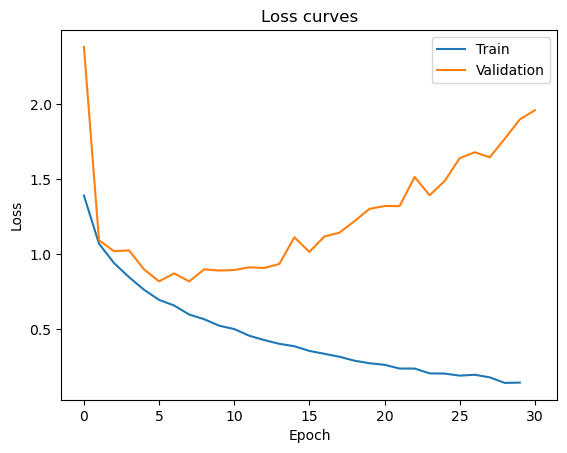

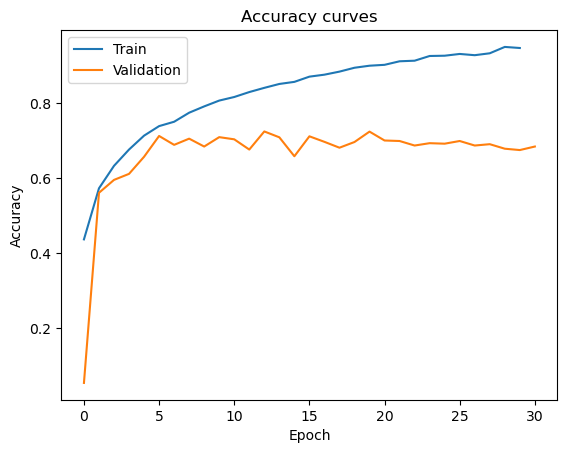

In [79]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### (e) continued

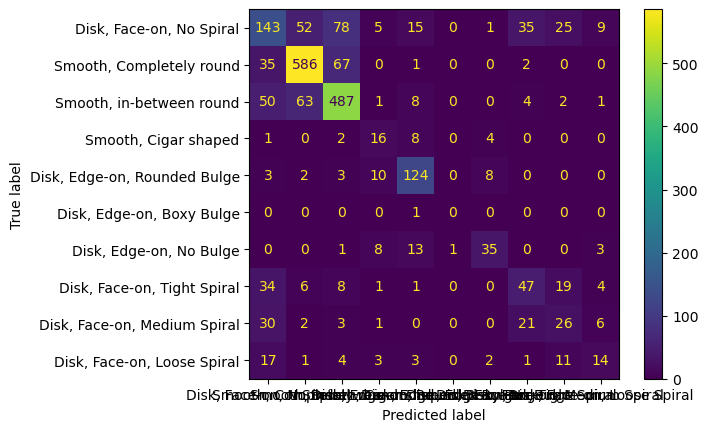

In [ ]:
# TODO: Evaluate the best validation model on the test set and create a confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate(model, test_loader):
    predictions = []
    ground_truth = []
    
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            ground_truth.extend(labels.tolist())
    
    return predictions, ground_truth

predictions, ground_truth = evaluate(bestmodel, test_loader)
cm = confusion_matrix(ground_truth, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()

## 3 Positional Encoding

$ E \in \mathbb{R}^{p\times n} $

$ E_{(2k), i} = \sin\left(i \cdot \exp\left(-\frac{2k \cdot \log(10000)}{p}\right)\right) $

$ E_{(2k+1), i} = \cos\left(i \cdot \exp\left(-\frac{2k \cdot \log(10000)}{p}\right)\right) $